In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET

from dotenv import load_dotenv
load_dotenv()

DETRAC_ROOT = os.getenv("DETRAC_ROOT") 
print(f"DETRAC_ROOT is set to: {DETRAC_ROOT}")

IMAGES_PATH = os.path.join(DETRAC_ROOT,"images", "MVI_20011")
ANNOTATIONS_PATH = os.path.join(DETRAC_ROOT,"annotations",  "DETRAC-Train-Annotations-XML", "MVI_20011.xml")



DETRAC_ROOT is set to: /Users/victorhugogermano/Downloads/DETRAC


In [2]:

def load_detrac_annotations(xml_file):
    """Load DETRAC annotations from XML file"""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    annotations = {}
    for frame in root.findall('frame'):
        frame_num = int(frame.get('num'))
        annotations[frame_num] = []
        
        for target in frame.findall('.//target'):
            bbox = target.find('box')
            if bbox is not None:
                x = float(bbox.get('left'))
                y = float(bbox.get('top'))
                w = float(bbox.get('width'))
                h = float(bbox.get('height'))
                target_id = target.get('id')
                
                annotations[frame_num].append({
                    'id': target_id,
                    'bbox': [x, y, w, h]
                })
    
    return annotations

def visualize_frame_with_annotations(image_path, annotations, frame_num):
    """Visualize a frame with bounding box annotations"""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    
    if frame_num in annotations:
        for ann in annotations[frame_num]:
            x, y, w, h = ann['bbox']
            rect = plt.Rectangle((x, y), w, h, linewidth=2, 
                               edgecolor='red', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x, y-10, f"ID: {ann['id']}", 
                    color='red', fontsize=12, weight='bold')
    
    plt.title(f"Frame {frame_num}")
    plt.axis('off')
    plt.show()

def explore_dataset_statistics(images_path, annotations):
    """Explore basic dataset statistics"""
    image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.jpg')])
    
    print(f"Dataset Statistics:")
    print(f"- Total frames: {len(image_files)}")
    print(f"- Annotated frames: {len(annotations)}")
    
    # Sample image properties
    if image_files:
        sample_image = cv2.imread(os.path.join(images_path, image_files[0]))
        height, width, channels = sample_image.shape
        print(f"- Image dimensions: {width}x{height}")
        print(f"- Channels: {channels}")
    
    # Vehicle count statistics
    vehicle_counts = []
    all_bbox_sizes = []
    
    for frame_num, frame_annotations in annotations.items():
        vehicle_counts.append(len(frame_annotations))
        for ann in frame_annotations:
            x, y, w, h = ann['bbox']
            all_bbox_sizes.append((w, h))
    
    if vehicle_counts:
        print(f"- Average vehicles per frame: {np.mean(vehicle_counts):.2f}")
        print(f"- Max vehicles in frame: {np.max(vehicle_counts)}")
        print(f"- Min vehicles in frame: {np.min(vehicle_counts)}")
    
    if all_bbox_sizes:
        widths, heights = zip(*all_bbox_sizes)
        print(f"- Average bbox size: {np.mean(widths):.1f}x{np.mean(heights):.1f}")


Loading DETRAC annotations...
Dataset Statistics:
- Total frames: 664
- Annotated frames: 664
- Image dimensions: 960x540
- Channels: 3
- Average vehicles per frame: 11.53
- Max vehicles in frame: 16
- Min vehicles in frame: 6
- Average bbox size: 50.6x46.7


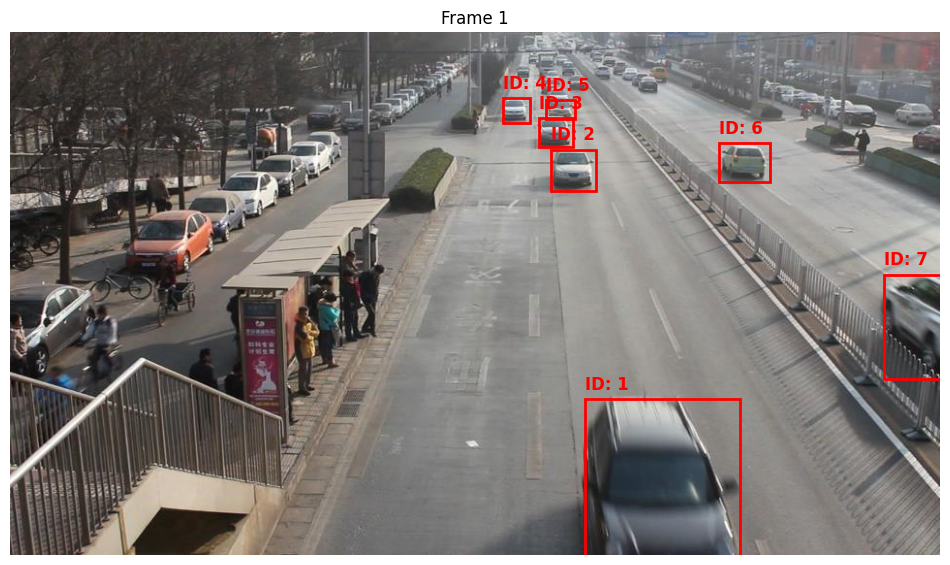

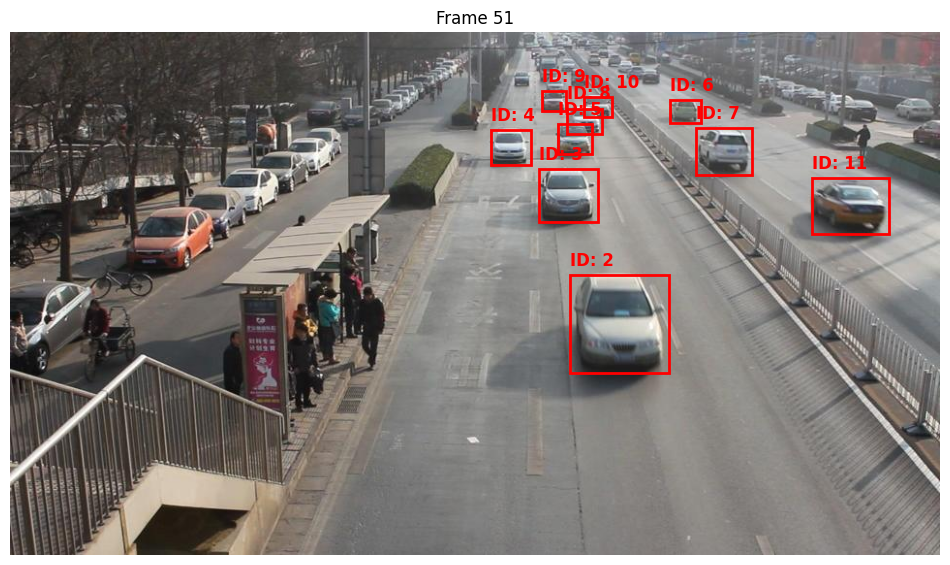

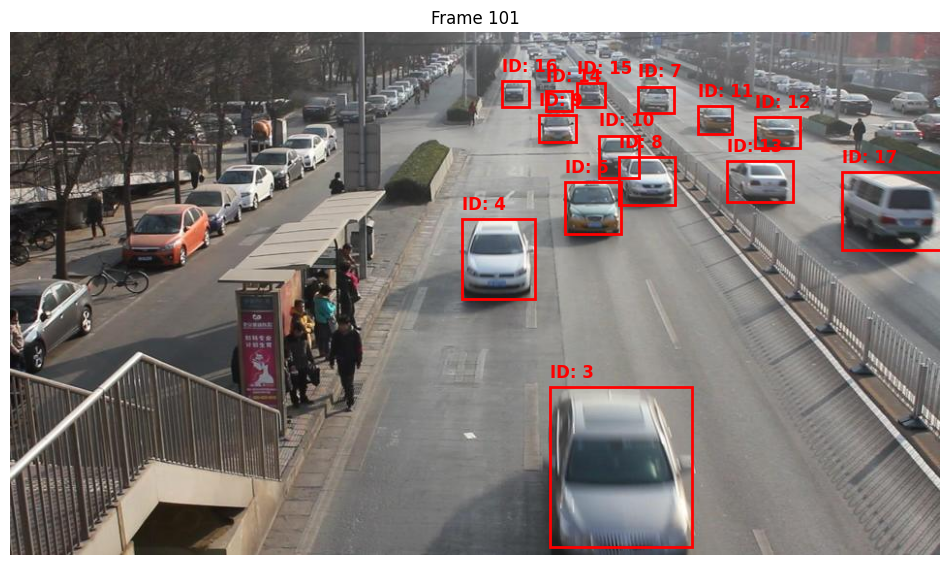

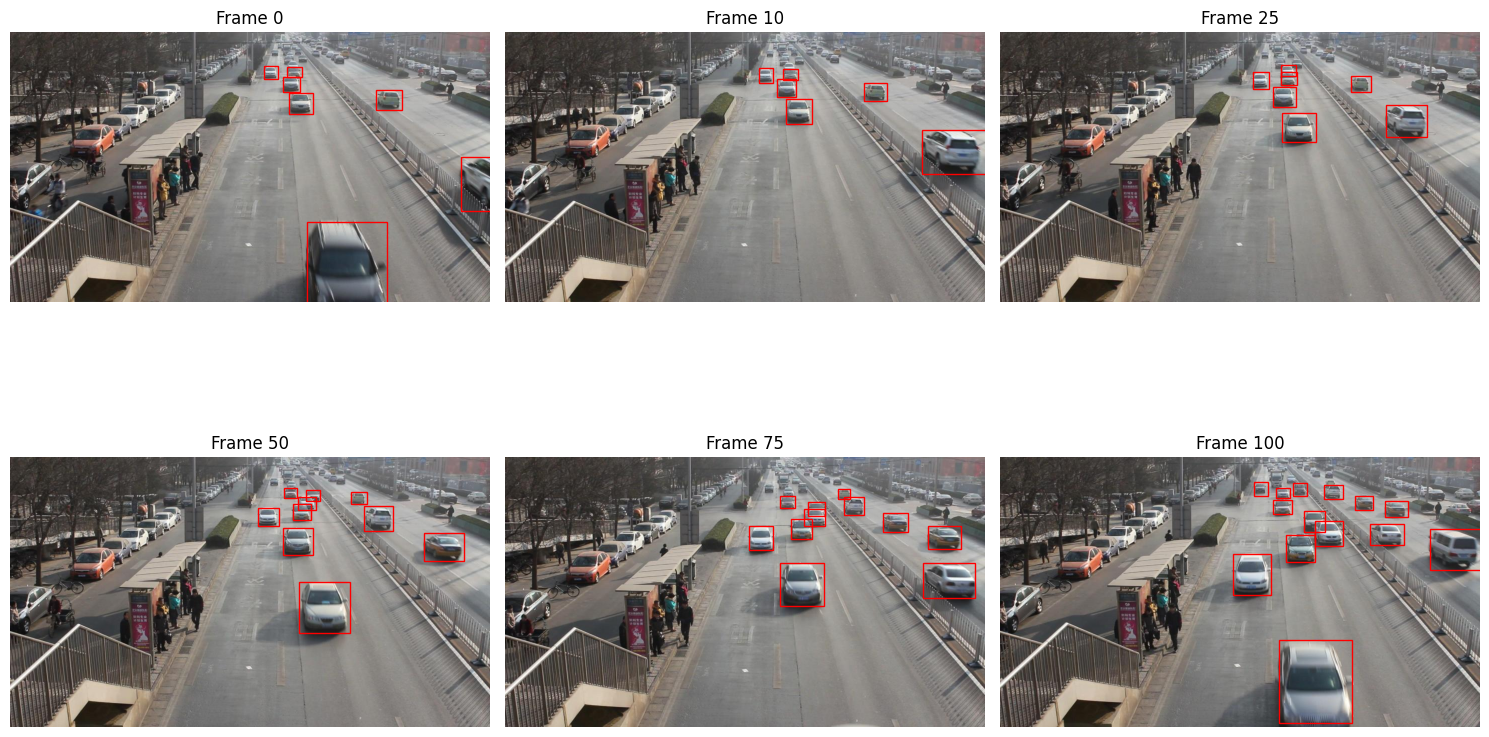

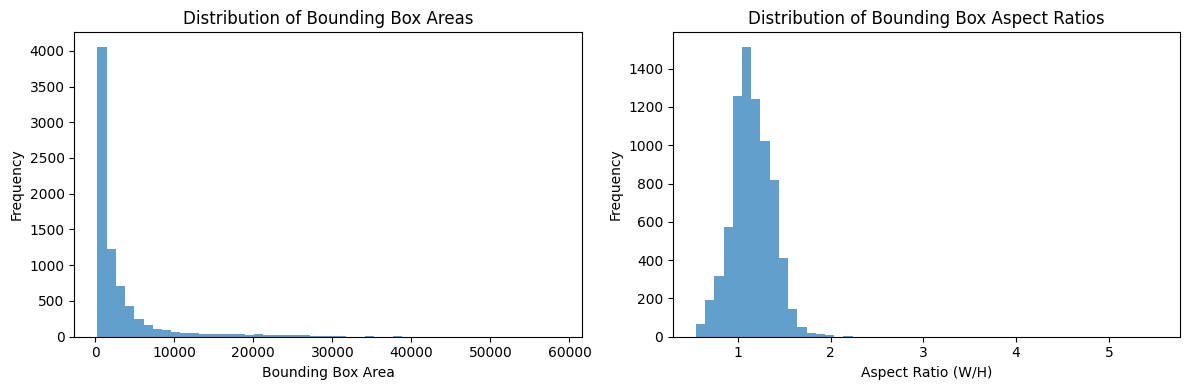


Dataset exploration complete!


In [5]:

# Load annotations
print("Loading DETRAC annotations...")
annotations = load_detrac_annotations(ANNOTATIONS_PATH)

# Explore dataset statistics
explore_dataset_statistics(IMAGES_PATH, annotations)

# Visualize sample frames
image_files = sorted([f for f in os.listdir(IMAGES_PATH) if f.endswith('.jpg')])

# Show first few frames
for i in [0, 50, 100]:
    if i < len(image_files):
        frame_num = int(image_files[i].split('.')[0].replace('img', ''))
        image_path = os.path.join(IMAGES_PATH, image_files[i])
        visualize_frame_with_annotations(image_path, annotations, frame_num)

# Create a subplot showing multiple frames
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, frame_idx in enumerate([0, 10, 25, 50, 75, 100]):
    if idx < 6 and frame_idx < len(image_files):
        image_path = os.path.join(IMAGES_PATH, image_files[frame_idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(image)
        axes[idx].set_title(f"Frame {frame_idx}")
        axes[idx].axis('off')
        
        # Add bounding boxes
        frame_num = int(image_files[frame_idx].split('.')[0].replace('img', ''))
        if frame_num in annotations:
            for ann in annotations[frame_num]:
                x, y, w, h = ann['bbox']
                rect = plt.Rectangle((x, y), w, h, linewidth=1, 
                                   edgecolor='red', facecolor='none')
                axes[idx].add_patch(rect)

plt.tight_layout()
plt.show()

# Analyze bbox size distribution
bbox_areas = []
aspect_ratios = []

for frame_annotations in annotations.values():
    for ann in frame_annotations:
        x, y, w, h = ann['bbox']
        bbox_areas.append(w * h)
        aspect_ratios.append(w / h if h > 0 else 0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(bbox_areas, bins=50, alpha=0.7)
plt.xlabel('Bounding Box Area')
plt.ylabel('Frequency')
plt.title('Distribution of Bounding Box Areas')

plt.subplot(1, 2, 2)
plt.hist(aspect_ratios, bins=50, alpha=0.7)
plt.xlabel('Aspect Ratio (W/H)')
plt.ylabel('Frequency')
plt.title('Distribution of Bounding Box Aspect Ratios')

plt.tight_layout()
plt.show()

print("\nDataset exploration complete!")